In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH273: Computational Workshop 1
## The radial distribution function

<img src="STUFF/gdr.png" width=400px>

In this session, we are going to play around with the radial distribution function, $g(r)$. As you may remember, the $g(r)$ represents the probability of finding a particle at a distance $r$ away from a given reference particle. Here, we are going to consider a hard sphere liquid, in two and three dimensions as well.

In [3]:
# Import a number is useful packages...
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
from STUFF.poisson_disc import Grid
import random 

### The 2D case

In [4]:
# Set the length and width (the x and y dimensions) of the box
length = 10.0 # can be any units you like. A meaningful choice: [Å]
width = length # This is a square 2D box

# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 0.6 # [Å] 

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)

# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))

# Do the sampling
data = np.array(grid.poisson(rand))
pos_x=np.array(data[:,0])
pos_y=np.array(data[:,1])

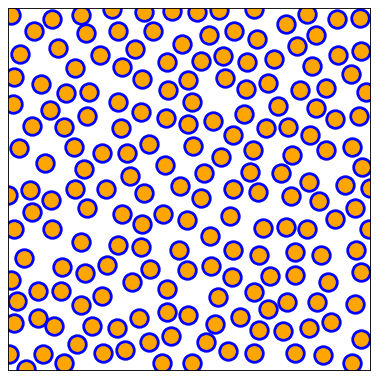

In [5]:
# Let's visualize the box and the particles - i.e. our hard sphere-ish liquid
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(pos_x,pos_y,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5)
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

<div class=warn>
Are we really considering a hard sphere liquid? Why? Write down your answer in a Markdown cell
<div/>

### Calculating the g(r)
Now that we have a configuration, we can calculate the g(r), using the function "py_rdf" defined below. This function takes in input the following arguments: 
* **r**   = a numpy array containing the positions of all the particles
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **dr**  = the resolution in r. The smaller this value, the greater the resolution
* **dim** = the dimensionality of the system (2 or 3 D)

In [6]:
def py_rdf(r, S, dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles  = len(r)
    rMax           = S/2.0;
    edges          = arange(0., rMax + dr, dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity  = len(r) / S**dim

    # Compute pairwise correlation for each particle
    for index in range(num_particles):

        d = 0.0
        for i in range(dim):
            dp = absolute(r[index,i] - r[:,i])
            mask = dp>S/2.0
            dp[mask] = S - dp[mask]
            d += dp*dp

        d = sqrt(d)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    g = g/(num_particles * numberDensity)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 3D
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i])

    return (radii, g)

Time to compute the g(r). We will *call* the py_rdf function we have just defined to do that. We will also interpolate the resulting points with a smooth function uscing the interp1d function from scipy

**Note**: in calculating the distances between the particles, we have to take into account the so-called periodic boundary conditions, which in turns implies that we can compute the g(r) only up to *half* the length of the box!

In [7]:
# Compute the g(r)
res_dr = 0.1 # resolution [Å]
n_data=np.array(data) # We store the atomic positions into a numpy array

In [8]:
# Call the py_rdf function. Note that the name of the arguments can be different, but not their order.
# For instance, we have called n_data the first argument, which is indicated as r in the definition
# of py_rdf above. Which is fine, Python will take care of that. But, we are not allowed to swap, say,
# n_data and length!!
rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub = interp1d(rad_py, g_r_py, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)

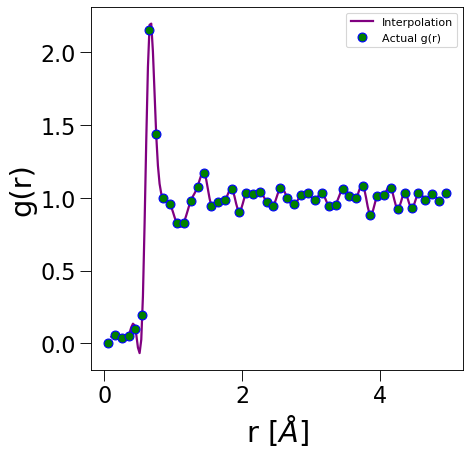

In [9]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r)
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='Interpolation') 

# Actual g(r) points
plt.plot(rad_py, g_r_py, 'o', markerfacecolor='green', markersize=8, markeredgecolor='blue', 
         linewidth=2.5, label='Actual g(r)')

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

<div class=warn>
    
Compute the $g(r)$ for a configuration obtained by setting ```min_r = 1.2``` and compare it with the one we have obtained for ```min_r = 0.6```
<div/>

In [10]:
# Set the minimum distance between the particles (as you can see, this is not really a hard sphere liquid! Why?)
min_r = 1.2 # [Å] 

# Generate a random arrangement of particles - according to an algorithm called Poisson sampling.
# Note that every time you run this cell, the algorithm will generate a DIFFERENT configuration!
grid = Grid(min_r, length, width)

# Random seed 
rand = (random.uniform(0, length), random.uniform(0, width))

# Do the sampling
data2 = np.array(grid.poisson(rand))
n_data2=np.array(data2)

pos_x2=np.array(n_data2[:,0])
pos_y2=np.array(n_data2[:,1])


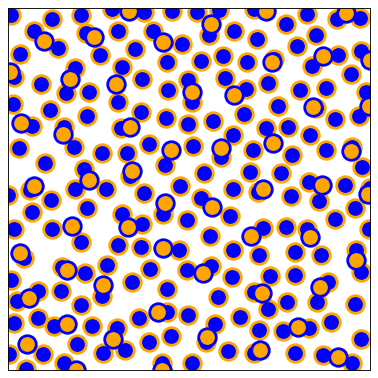

In [11]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(pos_x,pos_y,s=250, facecolors='blue', edgecolors='orange',linewidth=2.5, label='r_{min}=0.6 Å')
plt.scatter(pos_x2,pos_y2,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5, label='r_{min}=1.2 Å')
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

In [12]:
rad_py2, g_r_py2 = py_rdf(n_data2, length, res_dr, 2)

# We interpolate the result to get a smooth line connecting the dots
res = 200 # How many points do we want in the interpolated line
safe = 1e-1 # Don't you worry about this one...

# We interpolate the g(r) using a cubic spline
f_cub2 = interp1d(rad_py2, g_r_py2, kind='cubic')

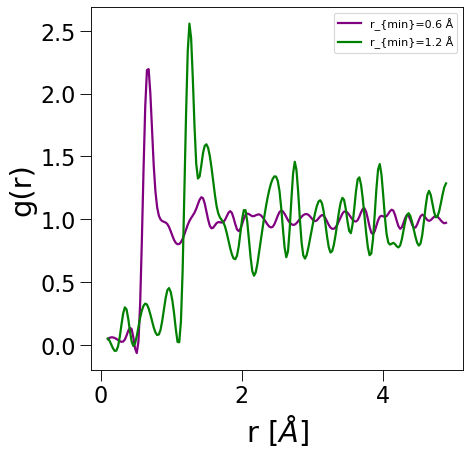

In [13]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r) with r_min=0.6
plt.plot(xnew, f_cub(xnew), color='purple', linestyle='solid', linewidth=2.0, label='r_{min}=0.6 Å') 
# Interpolated g(r) with r_min=1.2
plt.plot(xnew, f_cub2(xnew), color='green', linestyle='solid', linewidth=2.0, label='r_{min}=1.2 Å') 

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

### The need for an ensemble average
As you can see, the g(r) looks a bit spiky. The reason? Well, we have considered just **one** configuration of our hard sphere liquid! We know that in order to get this right we need to perform an ensemble average, i.e. we have to average our g(r) over different configurations. How? We do a loop! Crucially, every time you call the grid.poisson function, you generate a different configuration - handy!

In [14]:
# This may take a while, check the * in the [] on the left of the cell, when that's gone, you are good to go

n_confs=50 # Number of configurations we are going to take into account

g_r=np.zeros((len(g_r_py),n_confs))
g_r_ave=np.zeros(len(g_r_py))

n_ave=0
for i in range(0,n_confs):
    data = grid.poisson(rand)
    n_data=np.array(data)
    rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)
    g_r[:,i]=g_r_py
    n_ave=n_ave+len(n_data)

# Ensemble average of the g(r)
g_r_ave=(np.sum(g_r, axis=1))/n_confs

# Average number of particles (needed to calculate the coordination number, see below...)
n_ave=n_ave/n_confs

# We interpolate the g(r) using a cubic spline
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')

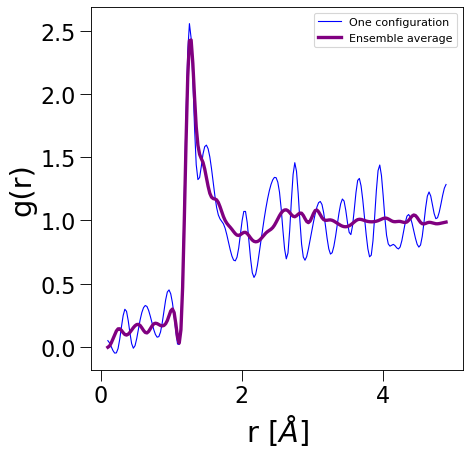

In [15]:
# Comparison of the g(r) for just one configuration and that obtained upon taking an ensemble average
# Let's plot everything for r_min=1.2 [Å]
f_cub_ave = interp1d(rad_py, g_r_ave, kind='cubic')
xnew = np.linspace(safe, (length/2.0)-safe, num=res, endpoint=True)
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k') # figsize determine the actual size of the figure
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(xnew, f_cub2(xnew), color='blue', linestyle='solid', linewidth=1.0, label='One configuration')
plt.plot(xnew, f_cub_ave(xnew), color='purple', linestyle='solid', linewidth=3.0, label='Ensemble average')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.legend()
plt.show()

### The coordination number
Now that we have our (ensemble averaged!) $g(r)$, we can compute the average coordination number $c_N$, which in two dimensions can be calculated from the $g(r)$ as follows: 

$$
c_N(r')_{2D} = 2\pi \rho \int_0^{r'} g(r) r   dr
$$

In [16]:
# Integrate the g(r) to get the coordination number as a function of r || rad_py g_r_ave
d2dr=rad_py[1]-rad_py[0] # dr
density=n_ave/(length*length) # number density, 2D
cn_2d=np.zeros((len(rad_py),2))

for i in range(0,len(rad_py)):
    cn_2d[i,0]=rad_py[i]
    cn_2d[i,1]=cn_2d[i,1]+(g_r_ave[i]*rad_py[i]*d2dr)

cn_2d[:,1]=cn_2d[:,1]*(2*np.pi*density)

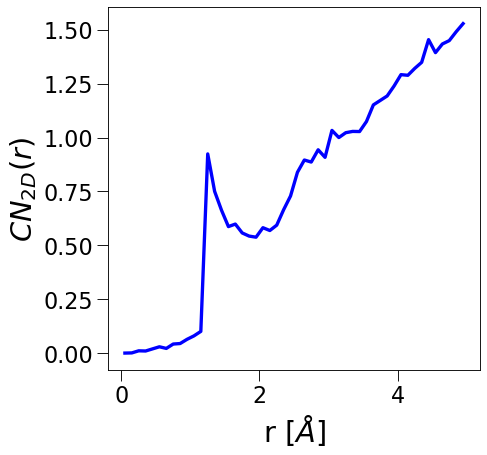

In [17]:
# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_2d[:,0], cn_2d[:,1], color='blue', linestyle='solid', linewidth=3.0)
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2D}(r)$', fontsize=26)
plt.show()

<div class=warn>
    
Compare the average coordination number for two hard sphere liquids obtained by setting ```min_r = 0.6``` and ```min_r = 1.2```
<div/>

In [18]:
# Set the length and width (the x and y dimensions) of the box
length = 10.0 # can be any units you like. A meaningful choice: [Å]
width = length # This is a square 2D box
min_r = 0.6 # [Å] 

grid = Grid(min_r, length, width)

n_confs=10 # Number of configurations we are going to take into account

g_r6=np.zeros((len(g_r_py),n_confs))
g_r_ave6=np.zeros(len(g_r_py))

n_ave6=0
for i in range(0,n_confs):
    data6 = grid.poisson(rand)
    n_data6=np.array(data6)
    rad_py6, g_r_py6 = py_rdf(n_data6, length, res_dr, 2)
    g_r6[:,i]=g_r_py6
    n_ave6=n_ave6+len(n_data6)   
    
# Ensemble average of the g(r)
g_r_ave6=(np.sum(g_r6, axis=1))/n_confs

# Average number of particles (needed to calculate the coordination number, see below...)
n_ave6=n_ave6/n_confs

# We interpolate the g(r) using a cubic spline
f_cub_ave6 = interp1d(rad_py6, g_r_ave6, kind='cubic')

In [19]:
pos_x_6=np.array(n_data6[:,0])
pos_y_6=np.array(n_data6[:,1])   

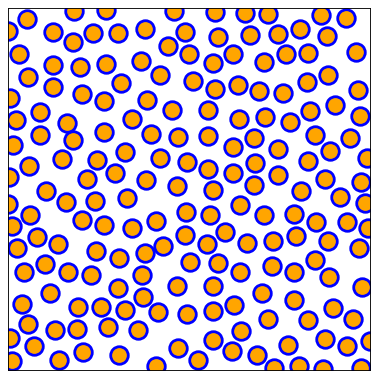

In [20]:
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(pos_x_6,pos_y_6,s=250, facecolors='orange', edgecolors='blue',linewidth=2.5, label='r_{min}=1.2 Å')
plt.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
plt.xlim(0,length)
plt.ylim(0,length)
plt.gca().set_aspect('equal', adjustable='box')
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

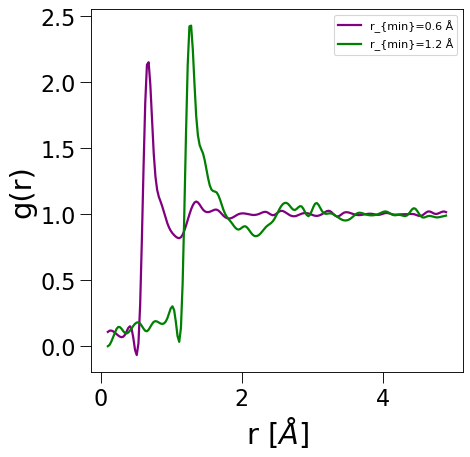

In [21]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated g(r) with r_min=0.6
plt.plot(xnew, f_cub_ave6 (xnew), color='purple', linestyle='solid', linewidth=2.0, label='r_{min}=0.6 Å') 
# Interpolated g(r) with r_min=1.2
plt.plot(xnew, f_cub_ave(xnew), color='green', linestyle='solid', linewidth=2.0, label='r_{min}=1.2 Å') 

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

In [22]:
# Integrate the g(r) to get the coordination number as a function of r || rad_py g_r_ave
d2dr=rad_py6[1]-rad_py6[0] # dr
density6=n_ave6/(length*length) # number density, 2D
cn_2d6=np.zeros((len(rad_py6),2))

for i in range(0,len(rad_py6)):
    cn_2d6[i,0]=rad_py6[i]
    cn_2d6[i,1]=cn_2d6[i,1]+(g_r_ave6[i]*rad_py6[i]*d2dr)

cn_2d6[:,1]=cn_2d6[:,1]*(2*np.pi*density6)

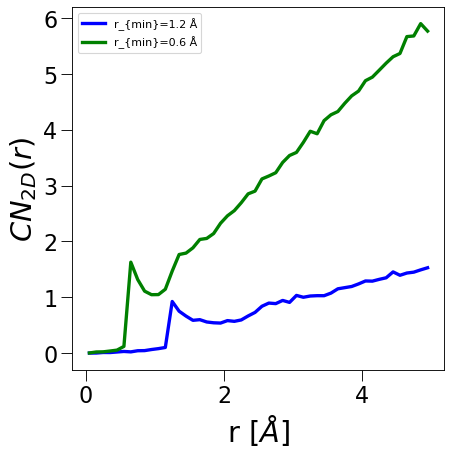

In [23]:
# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_2d[:,0], cn_2d[:,1], color='blue', linestyle='solid', linewidth=3.0, label='r_{min}=1.2 Å')
plt.plot(cn_2d6[:,0], cn_2d6[:,1], color='green', linestyle='solid', linewidth=3.0, label='r_{min}=0.6 Å')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2D}(r)$', fontsize=26)
plt.legend()
plt.show()

### The 3D case

In [24]:
tdr=0.5 # r is the minimum radius between points
tdlength = 4.0 # length and width are rectangular bounds
tdwidth = tdlength
tdheight = tdwidth
grid = Grid(tdr, tdlength, tdwidth, tdheight)
rand = (random.uniform(0, tdlength), random.uniform(0, tdwidth), random.uniform(0, tdheight))
tddata = grid.poisson(rand, 30)


In [25]:
np_tddata=np.array(tddata)
pos_x=np.array(np_tddata[:,0])
pos_y=np.array(np_tddata[:,1])
pos_z=np.array(np_tddata[:,2])

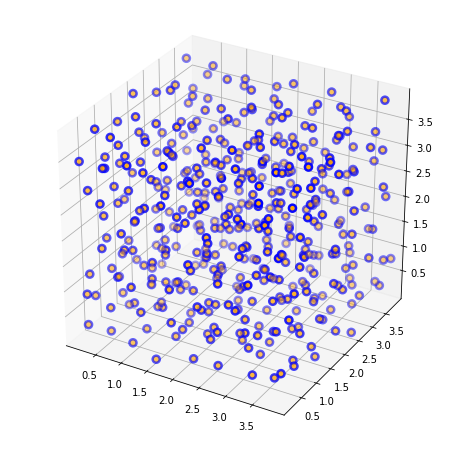

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_x,pos_y,pos_z,s=50, facecolors='orange', edgecolors='blue',linewidth=2.5)
ax.margins(0,0,0)

<div class=warn>

* Compute the $g(r)$. Note that in order to normalize it correctly, you will have to modify the ```py_rdf``` function to take into account the three dimensional case. In particular, the $g(r)$ will have to be normalized by:

$$
r^2 4.0\pi dr 
$$

* $c_N$, which in three dimensions can be calculated from the $g(r)$ as follows: 

$$
c_N(r')_{3D} = 4\pi \int_0^{r'} g(r) r^2 \rho  dr
$$
<div/>

In [27]:
tddr=0.05
tdrad, tdg_r = py_rdf(np_tddata,tdlength,tddr,3)
tdf = interp1d(tdrad,tdg_r, kind="cubic")
tdx = np.linspace(safe, (tdlength/2.0)-safe, num=res, endpoint=True)

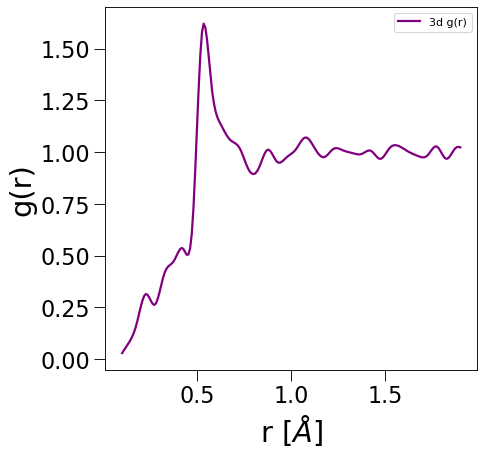

In [28]:
# Plot
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)

# Interpolated 3D g(r) 
plt.plot(tdx, tdf(tdx), color='purple', linestyle='solid', linewidth=2.0, label="3d g(r)") 


# # Interpolated g(r) with r_min=0.6
# plt.plot(rad_py6, g_r_ave6, color='purple', linestyle='solid', linewidth=2.0, label='r_{min}=0.6 Å') 
# # Interpolated g(r) with r_min=1.2
# plt.plot(rad_py, g_r_ave, color='green', linestyle='solid', linewidth=2.0, label='r_{min}=1.2 Å') 

plt.legend()
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('g(r)', fontsize=26)
plt.show()

In [29]:
delta_r=tdrad[1]-tdrad[0]
td_n=len(tddata)
td_density=td_n/(tdlength*tdlength*tdlength)
cn_3d=np.zeros((len(tdrad),2))

for i in range(0,len(tdrad)):
    cn_3d[i,0]=tdrad[i]
    cn_3d[i,1]=cn_3d[i,1]+(tdg_r[i]*tdrad[i]*tdrad[i]*delta_r)

cn_3d[:,1]=cn_3d[:,1]*(4*np.pi*td_density)

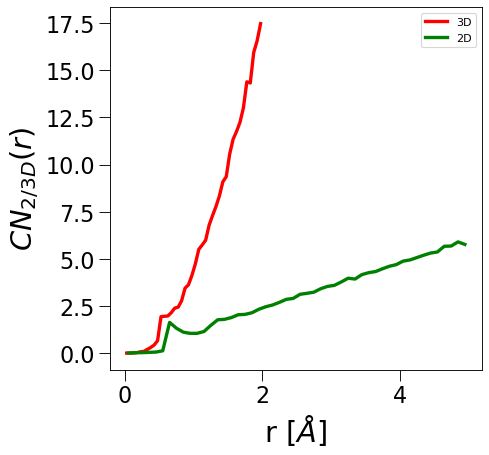

In [30]:
# Plot the coordination number as a function of r
plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.tick_params(axis='both', which='both', length=10.0, labelleft=True, labelbottom=True, labelsize=20.0)
plt.plot(cn_3d[:,0], cn_3d[:,1], color='red', linestyle='solid', linewidth=3.0, label='3D')
plt.plot(cn_2d6[:,0], cn_2d6[:,1], color='green', linestyle='solid', linewidth=3.0, label='2D')
plt.xlabel('r [$\AA$]', fontsize=26)
plt.ylabel('$CN_{2/3D}(r)$', fontsize=26)
plt.legend()
plt.show()